# 07 - Geometric transformations and landmarks

## Imports and functions

In [1]:
import numpy as np
import cv2
import sklearn
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, EuclideanTransform, warp, AffineTransform, SimilarityTransform, swirl, matrix_transform
from skimage.util import img_as_float, img_as_ubyte
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import math

In [17]:
def show_comparison(original, transformed, transformed_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(transformed)
    ax2.set_title(transformed_name)
    ax2.axis('off')
    io.show()
    
def show_comparison_two(original, transformed, first_name, second_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title(first_name)
    ax1.axis('off')
    ax2.imshow(transformed)
    ax2.set_title(second_name)
    ax2.axis('off')
    io.show()

## Image rotation

### Exercise 1 - Rotate

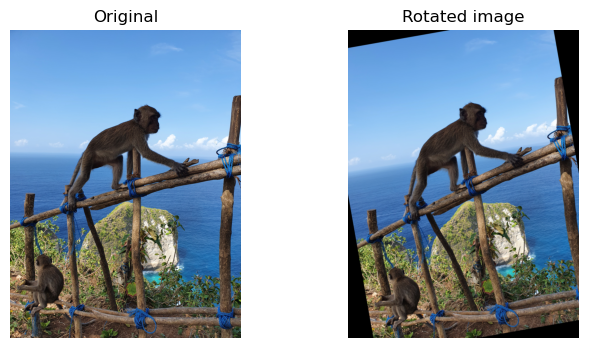

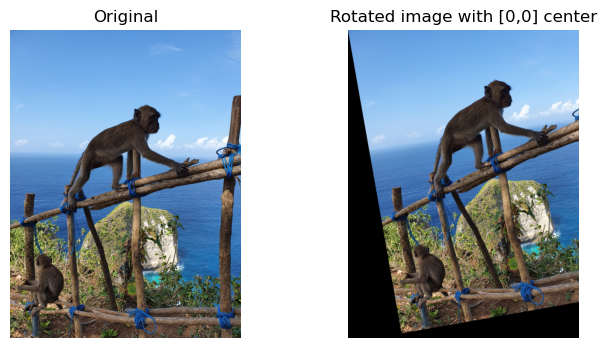

In [75]:
in_dir = 'data/'
im_org = io.imread(f'{in_dir}NusaPenida.png')

# angle in degrees - counter clockwise
rotation_angle = 10
rotated_img = rotate(im_org, rotation_angle)
show_comparison(im_org, rotated_img, "Rotated image")

## Rotation with center
rot_center = [0, 0]
rotated_img_center = rotate(im_org, rotation_angle, center=rot_center)
show_comparison(im_org, rotated_img_center, "Rotated image with [0,0] center")

### Exercise 2 - Reflect

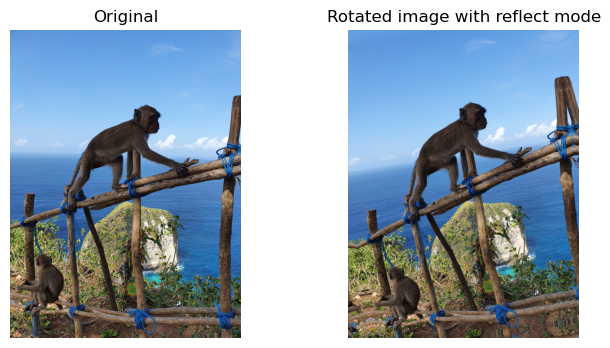

In [76]:
reflect_img = rotate(im_org, rotation_angle, mode="reflect")
show_comparison(im_org, reflect_img, "Rotated image with reflect mode")

### Exercise 3 - Reflect and wrap

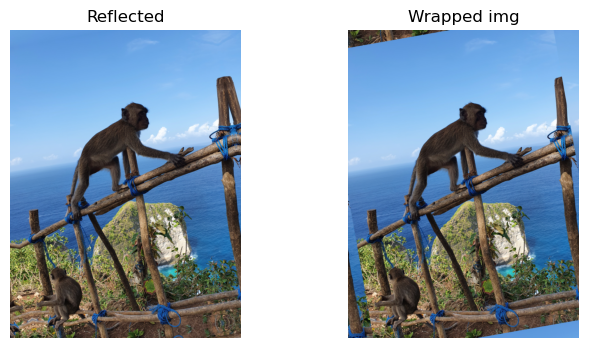

In [77]:
wrap_img = rotate(im_org, rotation_angle, mode="wrap")
show_comparison_two(reflect_img, wrap_img, 'Reflected',"Wrapped img")

### Exercise 4 -Cval

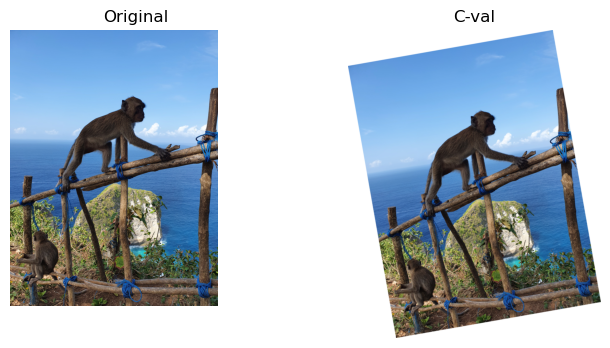

In [78]:
cval_img = rotate(im_org, rotation_angle, resize=True, mode="constant", cval=1) # 
show_comparison(im_org, cval_img, "C-val")

### Exercise 5 - Resizing

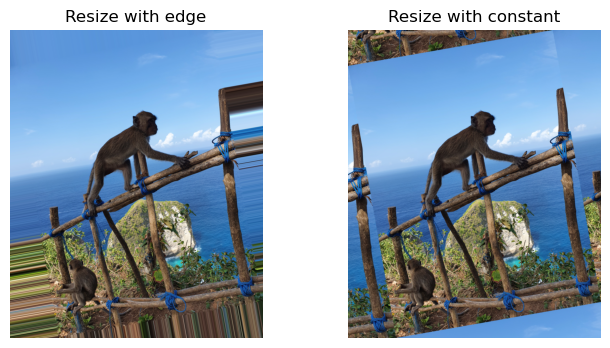

In [63]:
resize_img1 = rotate(im_org, rotation_angle, resize=True, mode="edge")
resize_img2 = rotate(im_org, rotation_angle, resize=True, mode="wrap")
show_comparison_two(resize_img1, resize_img2, "Resize with edge", "Resize with constant")

## Euclidean image transformation

### Exercise 6

The matrix is used to transform points using homogenous coordinates.

In [36]:
# angle in radians - counter clockwise
rotation_angle = 10.0 * math.pi / 180.
trans = [10, 20]
tform = EuclideanTransform(rotation=rotation_angle, translation=trans)
print(tform.params)

[[ 0.98480775 -0.17364818 10.        ]
 [ 0.17364818  0.98480775 20.        ]
 [ 0.          0.          1.        ]]


### Exercise 7 - Warp

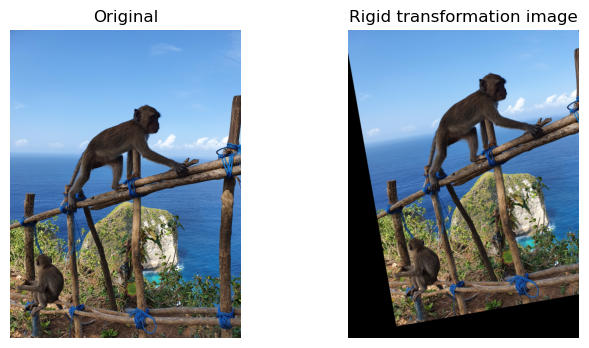

In [80]:
transformed_img = warp(im_org, tform)
#transformed_img = warp(im_org, tform.inverse)
show_comparison(im_org, transformed_img, "Rigid transformation image")

### Exercise 8
Construct a Euclidean transformation with only rotation. Test the transformation and the invers transformation and notice the effect.

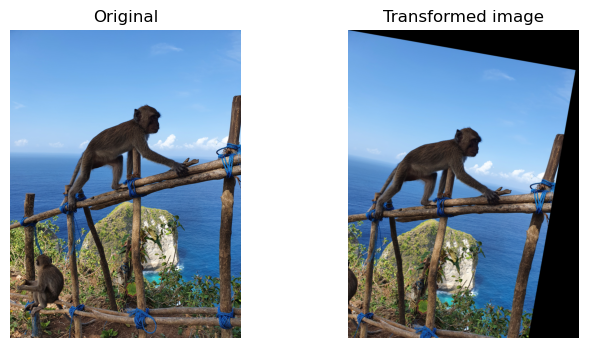

In [81]:
rotation_angle = 10.0 * math.pi / 180.
trans = [0, 0]
tform_rotate = EuclideanTransform(rotation=rotation_angle, translation=trans)
#transformed_img = warp(im_org, tform_rotate)
transformed_img = warp(im_org, tform_rotate.inverse)
show_comparison(im_org, transformed_img, "Transformed image")

## Similarity transform of image

### Exercise 9
Define a SimilarityTransform with an angle of 15 degrees, a translation of (40, 30) and a scaling of 0.6 and test it on the image.

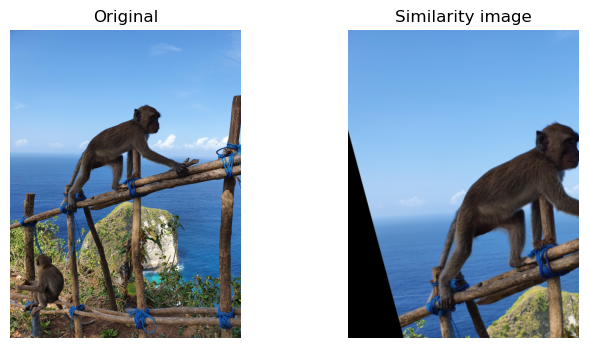

In [82]:
rotation_angle = 15.0 * math.pi / 180.
sim_tform = SimilarityTransform(rotation=rotation_angle, translation=(40,30), scale=0.6)

sim_img = warp(transformed_img, sim_tform)
show_comparison(im_org, sim_img, "Similarity image")

## The swirl image transformation

### Exercise 10

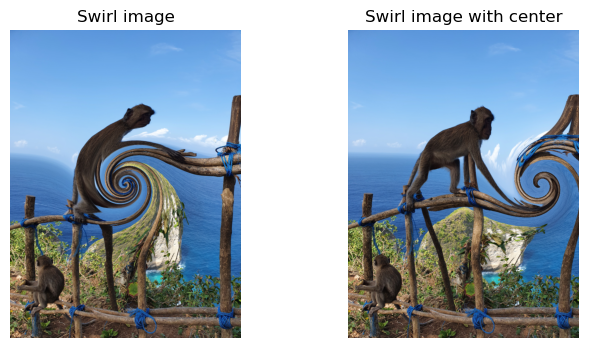

In [87]:
str = 10
rad = 300
swirl_img1 = swirl(im_org, strength=str, radius=rad)
str = 10
rad = 300
c = [500, 400]
swirl_img2 = swirl(im_org, strength=str, radius=rad, center=c)
show_comparison_two(swirl_img1, swirl_img2, "Swirl image", "Swirl image with center")

## Landmark based registration

### Exercise 11 - Overlap

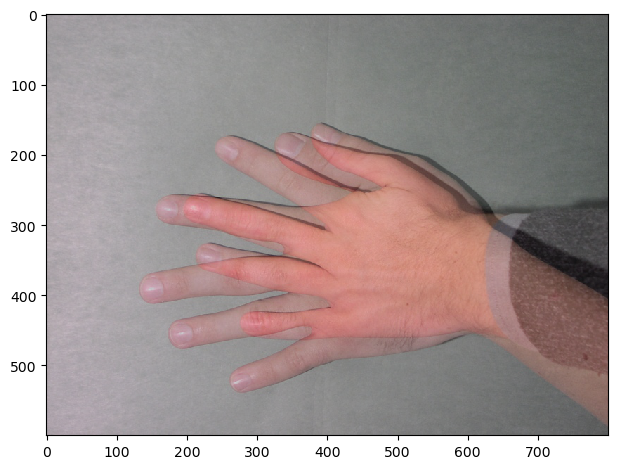

In [88]:
src_img = io.imread(f'{in_dir}Hand1.jpg')
dst_img = io.imread(f'{in_dir}Hand2.jpg')
blend = 0.5 * img_as_float(src_img) + 0.5 * img_as_float(dst_img)
io.imshow(blend)
io.show()

## Manual landmark annotation

### Exercise 12 - Manual landmarks

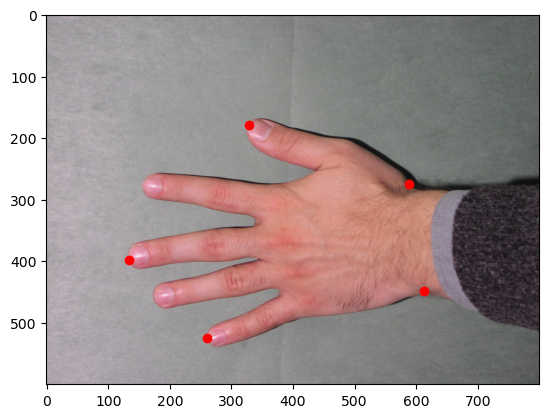

In [89]:
src = np.array([[588, 274], [328, 179], [134, 398], [260, 525], [613, 448]])

plt.imshow(src_img)
plt.plot(src[:, 0], src[:, 1], '.r', markersize=12)
plt.show()

### Exercise 13 

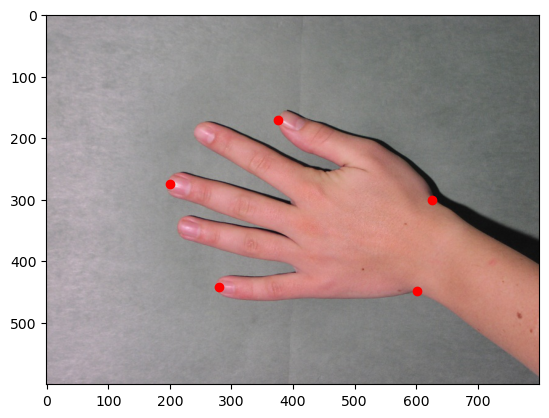

In [107]:
dst = np.array([[625, 300], [375, 170], [200, 275], [280, 442], [602, 448]])

plt.imshow(dst_img)
plt.plot(dst[:, 0], dst[:, 1], '.r', markersize=12)
plt.show()

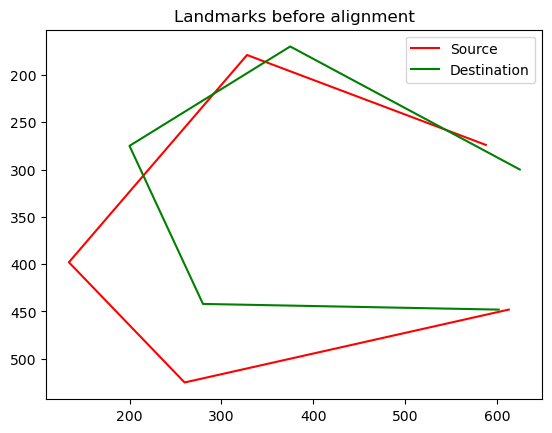

In [108]:
fig, ax = plt.subplots()
ax.plot(src[:, 0], src[:, 1], '-r', markersize=12, label="Source")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()

### Exercise 14 - Objective function


To calculate how well two sets of landmarks are aligned, we can compute the *objective function*:

$$ F = \sum_{i=1}^N \|a_i - b_i\|^2 \enspace ,$$

here $a_i$ are the landmarks in the destination image and $b_i$ are the landmarks in the source image.

In [109]:
e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f = error_x + error_y
print(f"Landmark alignment error F: {f}")

Landmark alignment error F: 31230


In [123]:
tform = EuclideanTransform()
tform.estimate(src, dst)
src_transform = matrix_transform(src, tform.params)
src_transform

array([[635.81315477, 288.6064131 ],
       [406.87457255, 133.00395305],
       [165.27780521, 298.01304979],
       [256.45875351, 451.93197217],
       [617.57571396, 463.44461188]])

### Exercise 15
Visualize the transformed source landmarks together with the destination landmarks. Also compute the objective function **F** using the transformed points. 

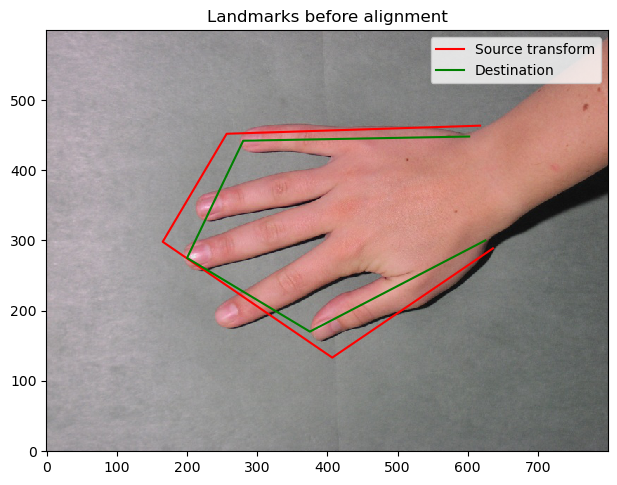

In [129]:
fig, ax = plt.subplots()
io.imshow(dst_img)
ax.plot(src_transform[:, 0], src_transform[:, 1], '-r', markersize=12, label="Source transform")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()

In [128]:
e_x = src_transform[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src_transform[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f = error_x + error_y
print(f"Landmark alignment error F: {f}")

Landmark alignment error F: 5500.638535015403


### Exercise 16


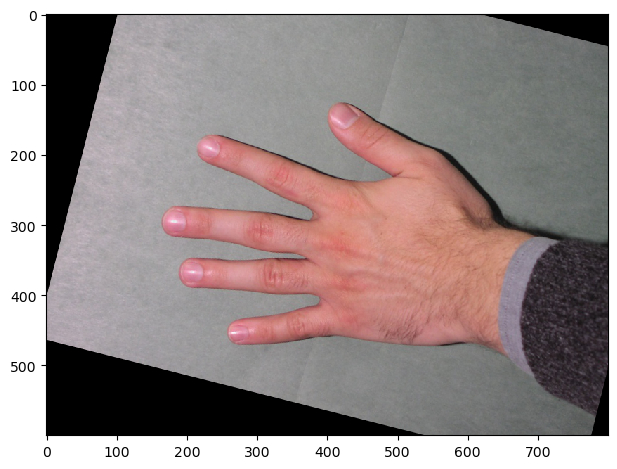

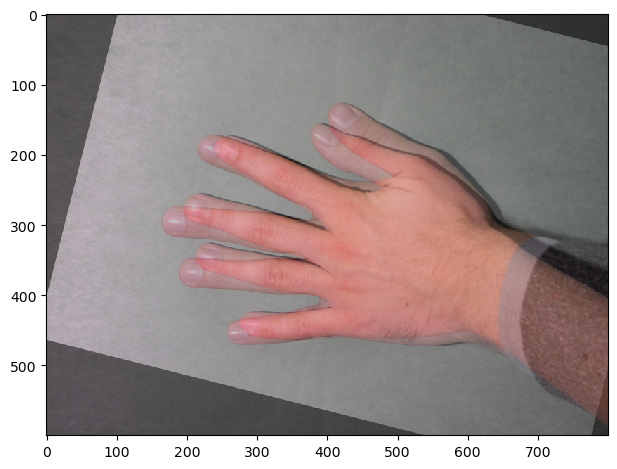

In [133]:
warped = warp(src_img, tform.inverse)
io.imshow(warped)
io.show()
blend = 0.5 * img_as_float(warped) + 0.5 * img_as_float(dst_img)
io.imshow(blend)
io.show()

## Video transformations
### Exercise 16 - Modify live video with swirl, rotate

In [138]:
!python data/Ex7-VideoImageTransformations.py

Starting image capture
Opening connection to camera
Starting camera loop
Stopping image loop
